# Imports

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from random import sample

import tensorflow as tf

import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Concatenate, Dense, Dropout, Lambda, Activation, Add, Average, Flatten, Multiply
from keras.layers.embeddings import Embedding
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils import np_utils

In [ ]:

%load_ext tensorboard

# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load in the data

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/one-m-capstone/data/combined.csv').drop(columns=['Unnamed: 0'])
movies = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/one-m-capstone/data/processed_movies.csv').drop(columns=['Unnamed: 0'])

In [ ]:
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation Children's Comedy
1,2,Jumanji (1995),Adventure Children's Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
df.head()

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zip,age_elab,occ_elab
0,1,Toy Story (1995),Animation Children's Comedy,1,5,978824268,F,1,10,48067,Under 18,K-12 student
1,48,Pocahontas (1995),Animation Children's Musical Romance,1,5,978824351,F,1,10,48067,Under 18,K-12 student
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,Under 18,K-12 student
3,260,Star Wars: Episode IV - A New Hope (1977),Action Adventure Fantasy Sci-Fi,1,4,978300760,F,1,10,48067,Under 18,K-12 student
4,527,Schindler's List (1993),Drama War,1,5,978824195,F,1,10,48067,Under 18,K-12 student


# Simple Embedding Model
This is a rudimentary model that functions by taking the input and turning them into an embedding, which is essnetially a n-dimensional matrix representation of the input. We define how many dimensions by `f_dim`. 10 seems to be pretty decent as this model becomes underfit rather quickly.





## Splitting Data

We use `LabelEncoder` to regularize our values and turn them into categorical inputs. Opting to go for a standard 20-80 test-train split. We also need to turn our inputs into dimensional arrays to feed two unique inputs at the model at once. 

In terms of deployment, we will use this model as it will be the fastest of the models when deployed without a TPU.

In [ ]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

X = df[['user', 'movie']].values
y = df["rating"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## Model


In [ ]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [ ]:
f_dim = 10 # this is the n-dimension of our embedding layers it is a hyper param

def Recommender(n_users, n_movies, n_factors):
    
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Reshape((n_factors,))(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([u, m])    
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)    

    return model

In [ ]:
model = Recommender(n_users, n_movies, f_dim)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 10)        60410       input_3[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 10)        38830       input_4[0][0]                    
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
early_stop = EarlyStopping(patience=2)
history = model.fit(x=X_train_array, y=y_train,
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=[early_stop]
)

Epoch 1/5
6253/6253 [==============================] - 10s 2ms/step - loss: 4.8213 - val_loss: 1.1309
Epoch 2/5
6253/6253 [==============================] - 9s 1ms/step - loss: 0.9666 - val_loss: 0.9096
Epoch 3/5
6253/6253 [==============================] - 9s 1ms/step - loss: 0.8919 - val_loss: 0.8908
Epoch 4/5
6253/6253 [==============================] - 10s 2ms/step - loss: 0.8792 - val_loss: 0.8814
Epoch 5/5
6253/6253 [==============================] - 10s 2ms/step - loss: 0.8656 - val_loss: 0.8685


In [ ]:
tf.keras.models.save_model(model, '/content/drive/MyDrive/Colab Notebooks/one-m-capstone/model.keras')

## Performance

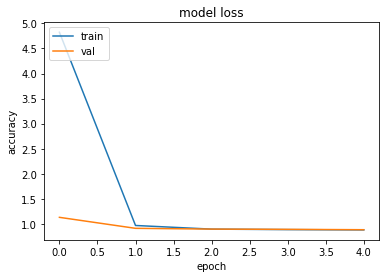

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

The model functions decently, a few issues would be that we actually can over or underpredict a value, we can change that by turning the activation of our final layer into *sigmoid* and then multiplying the result by 5 so we do not over or under predict.

# Improving the model

In this run we will change the final activation layer to a sigmoid function, and add a bias embedding layer. We will also add new inputs to the mix, as to take more advantage of our data frame. 

This along with all other modeling is a modified version of the work done here:
https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929.

Improvement Ideas were inspired by https://github.com/CVxTz/Recommender_keras

In [ ]:
df.head()

,movie_id,title,genres,user_id,rating,timestamp,gender,age,occupation,zip,age_elab,occ_elab,user,movie,genre
0,1,Toy Story (1995),Animation Children's Comedy,1,5.0,978824268,F,1,10,48067,Under 18,K-12 student,0,0,145
1,48,Pocahontas (1995),Animation Children's Musical Romance,1,5.0,978824351,F,1,10,48067,Under 18,K-12 student,0,47,153
2,150,Apollo 13 (1995),Drama,1,5.0,978301777,F,1,10,48067,Under 18,K-12 student,0,148,239
3,260,Star Wars: Episode IV - A New Hope (1977),Action Adventure Fantasy Sci-Fi,1,4.0,978300760,F,1,10,48067,Under 18,K-12 student,0,257,24
4,527,Schindler's List (1993),Drama War,1,5.0,978824195,F,1,10,48067,Under 18,K-12 student,0,523,262


In [ ]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

genre_enc = LabelEncoder()
df['genre'] = genre_enc.fit_transform(df['genres'].values)
n_genres = df['genre'].nunique()

job_enc = LabelEncoder()
df['job'] = job_enc.fit_transform(df['occupation'])
n_jobs = df['job'].nunique()

age_enc = LabelEncoder()
df['aged'] = age_enc.fit_transform(df['age'])
n_ages = df['aged'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

X = df[['user', 'movie', 'genre', 'job', 'aged']].values
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2]]

# Model 0.1

In [ ]:
f_dim = 25 # this is the n-dimension of our embedding layers it is a hyper param

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def Recommender(n_users, n_movies, n_genres, n_factors):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    uv = Flatten()(u)
    uv = Dropout(.2)(uv)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mv = Flatten()(m)
    mv = Dropout(.2)(mv)
  
    genre = Input(shape=(1,))
    g = EmbeddingLayer(n_genres, n_factors)(genre)
    gv = Flatten()(g)
    gv = Dropout(.2)(gv)
    
    x1 = Dot(axes=1)([u, m])
    x2 = Dot(axes=1)([u, g])
    x3 = Dot(axes=1)([m, g])

    x = Average()([x1, x2, x3])
    x = Multiply()([x, uv, mv, gv])
    x = Dropout(.2)(x)

    x = Dense(16, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(8, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Dense(16, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)

    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * 5)(x)    
    
    model = Model(inputs=[user, movie, genre], outputs=x)
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))    
    
    return model

In [ ]:
model = Recommender(n_users, n_movies, n_genres, f_dim)
#model.summary()

In [ ]:
early_stop = EarlyStopping(patience=4)
history = model.fit(x=X_train_array, y=y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=[early_stop]
)

Epoch 1/20
6253/6253 [==============================] - 29s 4ms/step - loss: 1.5250 - val_loss: 1.2869
Epoch 2/20
6253/6253 [==============================] - 27s 4ms/step - loss: 1.4813 - val_loss: 1.2871
Epoch 3/20
6253/6253 [==============================] - 27s 4ms/step - loss: 1.4816 - val_loss: 1.2909
Epoch 4/20
 252/6253 [>.............................] - ETA: 23s - loss: 1.4836

KeyboardInterrupt: ignored

# Model 2

In [ ]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

# Triple Input

In [ ]:
f_dim = 25 # this is the n-dimension of our embedding layers it is a hyper param

def Recommender(n_users, n_movies, n_genres, n_factors):
    user = Input(shape=(1,), name='UserInput')
    u = EmbeddingLayer(n_users, n_factors, name='UserEmbedding')(user)
    ub = EmbeddingLayer(n_users, 1, name='UserBiasEmbedding')(user)
    
    movie = Input(shape=(1,),  name='MovieInput')
    m = EmbeddingLayer(n_movies, n_factors, name='MovieEmbedding')(movie)
    mb = EmbeddingLayer(n_movies, 1, name='MovieBiasEmbedding')(movie)

    genre = Input(shape=(1,), name='GenreInput')
    g = EmbeddingLayer(n_genres, n_factors, name='GenreEmbedding')(genre)
    gb = EmbeddingLayer(n_genres, 1, name='GenreBiasEmbedding')(genre)

    x1 = Dot(axes=1)([u,m])
    x1 = Add()([x1, ub, mb])
    x2 = Dot(axes=1)([m,g])
    x2 = Add()([x2, mb, gb])

    x = Average()([x1,x2])
    x = Dropout(0.1)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * 5)(x) 

    model = Model(inputs=[user, movie, genre], outputs=x)
    opt = Adam(learning_rate=0.005)
    model.compile(loss='mean_squared_error', optimizer=opt)    
    
    return model

# Nightlie

In [ ]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

genre_enc = LabelEncoder()
df['genre'] = genre_enc.fit_transform(df['genres'].values)
n_genres = df['genre'].nunique()

job_enc = LabelEncoder()
df['job'] = job_enc.fit_transform(df['occupation'])
n_jobs = df['job'].nunique()

age_enc = LabelEncoder()
df['aged'] = age_enc.fit_transform(df['age'])
n_ages = df['aged'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

X = df[['user', 'movie', 'genre', 'job', 'aged']].values
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors, name=None):
      self.n_items = n_items
      self.n_factors = n_factors
      self.name = name
    
    def __call__(self, x):
      if self.name:
        x = Embedding(self.n_items, self.n_factors, name=self.name, embeddings_initializer='he_normal',
                    embeddings_regularizer=l2(1e-6))(x)
      else: 
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                    embeddings_regularizer=l2(1e-6))(x)
      x = Reshape((self.n_factors,))(x)
      return x

In [ ]:
f_dim = 25 # this is the n-dimension of our embedding layers it is a hyper param

def Recommender(n_users, n_movies, n_factors):
    user = Input(shape=(1,), name='UserInput')
    u = EmbeddingLayer(n_users, n_factors, name='UserEmbedding')(user)
    ub = EmbeddingLayer(n_users, 1, name='UserBiasEmbedding')(user)
    
    movie = Input(shape=(1,),  name='MovieInput')
    m = EmbeddingLayer(n_movies, n_factors, name='MovieEmbedding')(movie)
    mb = EmbeddingLayer(n_movies, 1, name='MovieBiasEmbedding')(movie)

    x = Dot(axes=1)([u,m])
    x = Add()([x, ub, mb])

    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * 5)(x) 

    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.005)
    model.compile(loss='mean_squared_error', optimizer=opt)    
    
    return model

In [ ]:
model = Recommender(n_users, n_movies, f_dim)
#model.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
early_stop = EarlyStopping(patience=3)
history = model.fit(x=X_train_array, y=y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=[early_stop]
)

Epoch 1/20
6253/6253 [==============================] - 20s 3ms/step - loss: 0.9591 - val_loss: 0.8383
Epoch 2/20
6253/6253 [==============================] - 19s 3ms/step - loss: 0.8862 - val_loss: 0.8280
Epoch 3/20
6253/6253 [==============================] - 19s 3ms/step - loss: 0.8769 - val_loss: 0.8239
Epoch 4/20
6253/6253 [==============================] - 20s 3ms/step - loss: 0.8740 - val_loss: 0.8211
Epoch 5/20
6253/6253 [==============================] - 19s 3ms/step - loss: 0.8708 - val_loss: 0.8180
Epoch 6/20
6253/6253 [==============================] - 20s 3ms/step - loss: 0.8705 - val_loss: 0.8247
Epoch 7/20
6253/6253 [==============================] - 19s 3ms/step - loss: 0.8689 - val_loss: 0.8187
Epoch 8/20
6253/6253 [==============================] - 19s 3ms/step - loss: 0.8664 - val_loss: 0.8179
Epoch 9/20
6253/6253 [==============================] - 20s 3ms/step - loss: 0.8669 - val_loss: 0.8191
Epoch 10/20
6253/6253 [==============================] - 19s 3ms/step - l

In [ ]:
model_2 = Model(input=model.get_layer('MovieInput').input, output = model.get_layer('MovieEmbedding').output) 
usrc = []
user_movie_embeddings = model_2.predict(x = usrc) # usrc = array of movie id liked by user
user_movie_embeddings = user_movie_embeddings.reshape(len(usrc),10) 
user_movie_bias = np.array([5 for temp in range(len(usrc))])

user_embedding, residuals, rank, s = np.linalg.lstsq(user_movie_embeddings,user_movie_bias, rcond=-1) # Get embedding for new user
user_embedding = user_embedding.reshape(1, 10) # User embedding based on choices of user

In [ ]:
f_dim = 35 # this is the n-dimension of our embedding layers it is a hyper param

def Recommender(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * 5)(x)    
    
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)    
    return model    
  

# New model Friday

In [ ]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

genre_enc = LabelEncoder()
df['genre'] = genre_enc.fit_transform(df['genres'].values)
n_genres = df['genre'].nunique()

job_enc = LabelEncoder()
df['job'] = job_enc.fit_transform(df['occupation'])
n_jobs = df['job'].nunique()

age_enc = LabelEncoder()
df['aged'] = age_enc.fit_transform(df['age'])
n_ages = df['aged'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

X = df[['user', 'movie', 'genre', 'job', 'aged']].values
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [ ]:
f_dim = 50
def Recommender(n_users, n_movies, n_factors):
    
    user = Input(shape=(1,), name='user_input')
    u = Embedding(n_users, n_factors, name='user_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Flatten(name='user_vector')(u)
    
    movie = Input(shape=(1,), name='movie_input')
    m = Embedding(n_movies, n_factors, name='movie_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Flatten(name='movie_vector')(m)
    
    
    x = Concatenate()([u, m])
    x = Dropout(.2)(x)
    x = Dense(1024, activation='relu', name='hidden_layer_01')(x)
    x = Dropout(.5)(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * 5)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(learning_rate=0.0001)
    model.compile(loss='mean_squared_error', optimizer=opt)    

    return model

model = Recommender(n_users, n_movies, f_dim)
model.summary()

Model: "model_138"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 50)        302050      user_input[0][0]                 
__________________________________________________________________________________________________
movie_embedding (Embedding)     (None, 1, 50)        194150      movie_input[0][0]                
__________________________________________________________________________________________

In [ ]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

genre_enc = LabelEncoder()
df['genre'] = genre_enc.fit_transform(df['genres'].values)
n_genres = df['genre'].nunique()

job_enc = LabelEncoder()
df['job'] = job_enc.fit_transform(df['occupation'])
n_jobs = df['job'].nunique()

age_enc = LabelEncoder()
df['aged'] = age_enc.fit_transform(df['age'])
n_ages = df['aged'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

X = df[['user', 'movie', 'genre', 'job', 'aged']].values
y = df['rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], X_train[:, 4]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3], X_test[:, 4]]

In [ ]:
## Experimental
f_dim = 50
def Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, n_factors):
    
    # USER
    # user
    user = Input(shape=(1,), name='user_input')
    uv = Embedding(n_users, n_factors, name='user_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    uv = Flatten(name='user_vector')(uv)

    # job
    job = Input(shape=(1,), name='job_input')
    jv = Embedding(n_jobs, n_factors, name='job_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(job)
    jv = Flatten(name='job_vector')(jv)

    # age
    age = Input(shape=(1,), name='age_input')
    a = Embedding(n_ages, n_factors, name='age_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(age)
    av = Flatten(name='age_vector')(a)

    # user vector
    u = Concatenate(name='user_concat')([uv,jv,av])
    u = Dropout(.2)(u)
    
    # ITEMS
    # movies
    movie = Input(shape=(1,), name='movie_input')
    m = Embedding(n_movies, n_factors, name='movie_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Flatten(name='movie_vector')(m)
    # genres
    genre = Input(shape=(1,), name='genre_input')
    g = Embedding(n_genres, n_factors, name='genre_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(genre)
    g = Flatten(name='genre_vector')(g)
    
    # items vector combined
    i = Concatenate(name='item_concat')([m,g])
    i = Dropout(.2)(i)

    # bias layers
    uvb = Embedding(n_users, 1, name='user_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    jb = Embedding(n_jobs, 1, name='job_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(job)
                  
    ab = Embedding(n_ages, 1, name='age_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(age)
    
    mb = Embedding(n_movies, 1, name='movie_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie) 
    gb = Embedding(n_movies, 1, name='genre_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(genre)

    # bias vectors
    ub = Multiply(name='user_bias_mult')([uvb,jb,ab])
    ib = Multiply(name='item_bias_mult')([mb,gb])
    
    x = Concatenate()([u, i])
    x = Dropout(.2)(x)
    x = Add()([x, ub, ib])
    x = Dense(1024, activation='relu', name='hidden_layer_01')(x)
    x = Dropout(.5)(x)
    x = Dense(512, activation='relu', name='hidden_layer_02')(x)
    x = Dropout(.5)(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * 5)(x)

    model = Model(inputs=[user, movie, genre, job, age], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)    

    return model

model = Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, f_dim)
model.summary()

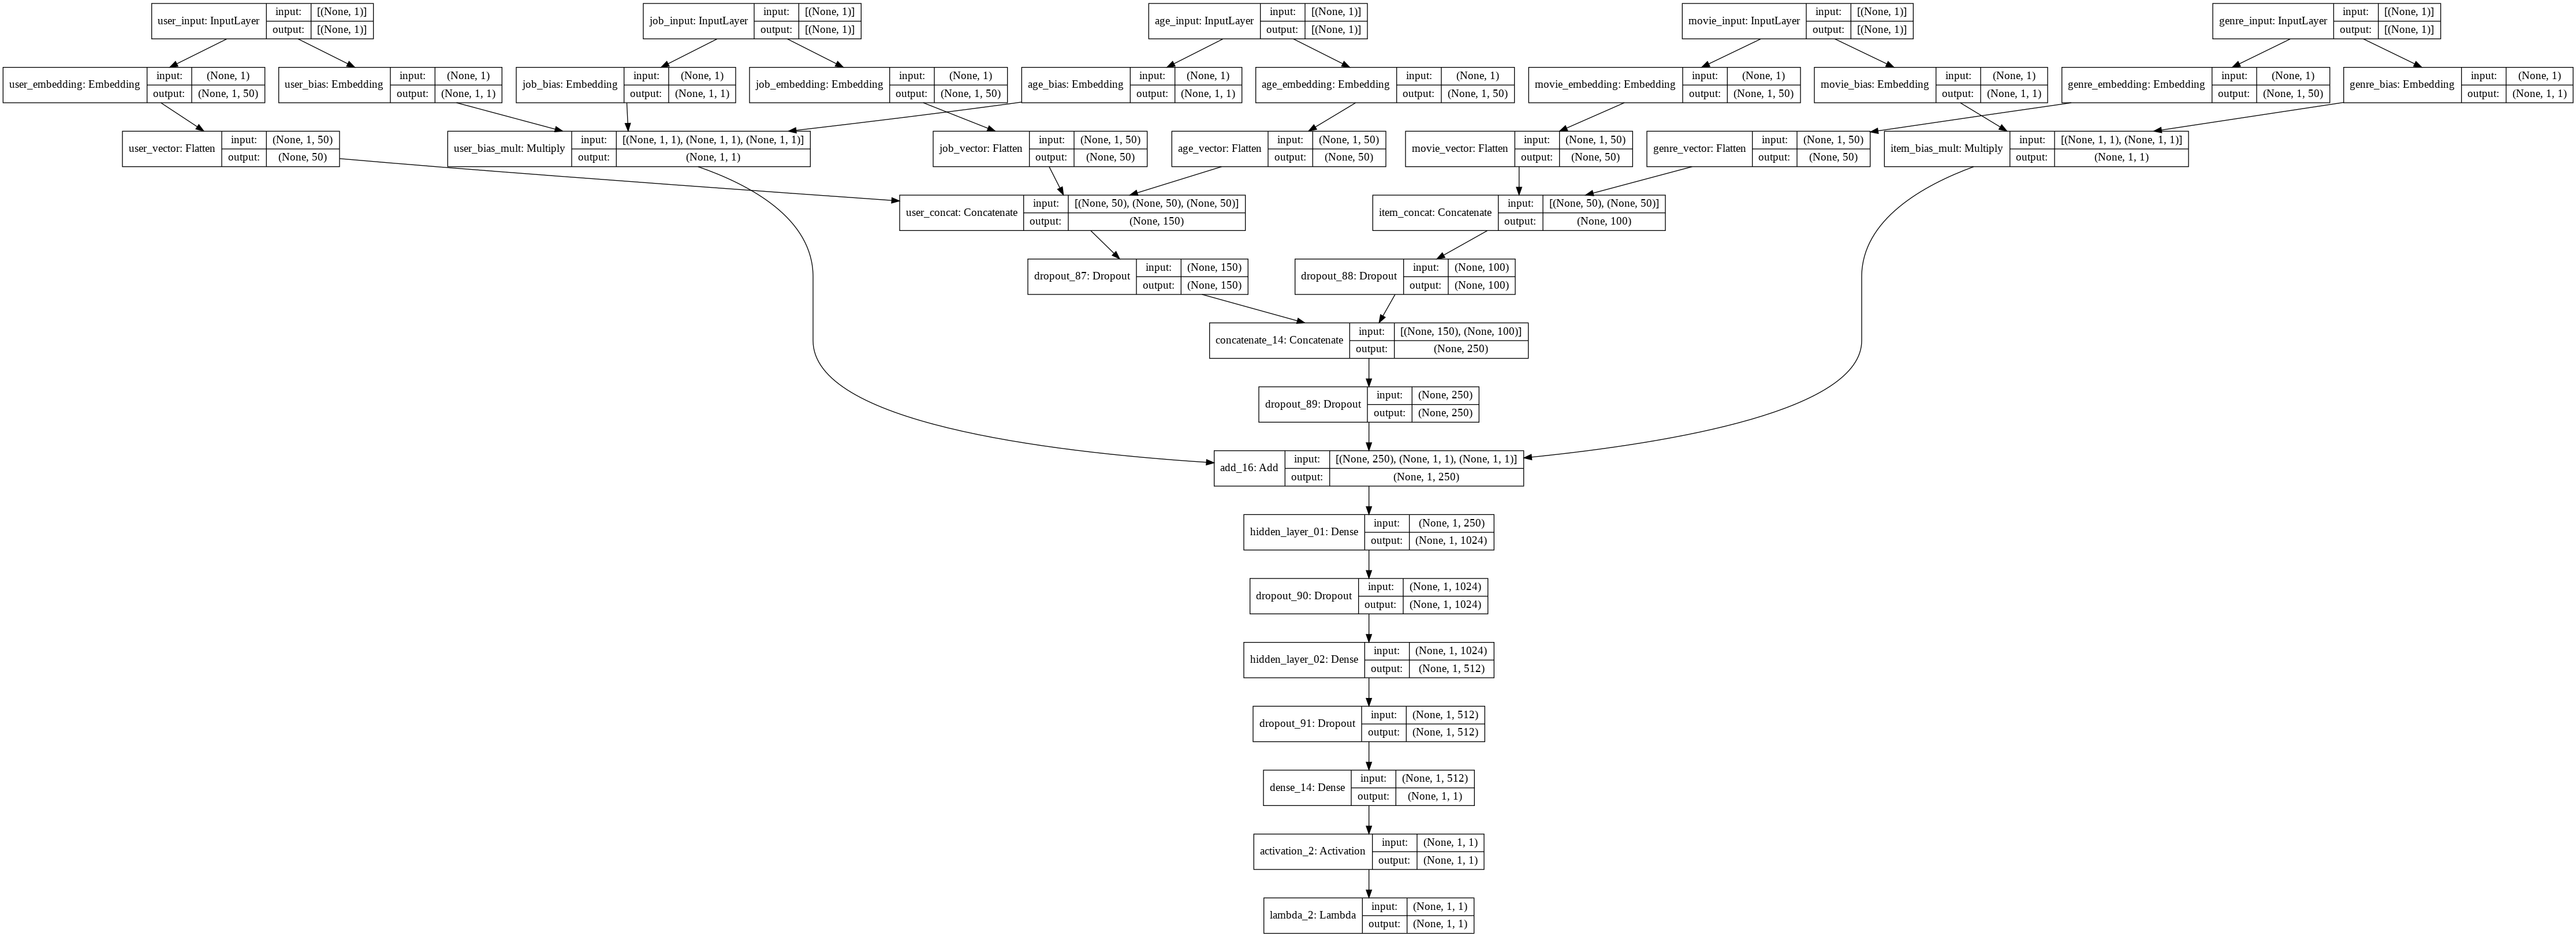

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=.005, patience=3)
history = model.fit(x=X_train_array, y=y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=[early_stop]
)

Epoch 1/20
5248/6253 [========================>.....] - ETA: 15s - loss: 0.9041

KeyboardInterrupt: ignored

# Softmax


In [ ]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

genre_enc = LabelEncoder()
df['genre'] = genre_enc.fit_transform(df['genres'].values)
n_genres = df['genre'].nunique()

job_enc = LabelEncoder()
df['job'] = job_enc.fit_transform(df['occupation'])
n_jobs = df['job'].nunique()

age_enc = LabelEncoder()
df['aged'] = age_enc.fit_transform(df['age'])
n_ages = df['aged'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

X = df[['user', 'movie', 'genre', 'job', 'aged']].values
y = df['rating']

# converting y to categorical
y_enc = LabelEncoder()
encoded_Y = y_enc.fit_transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_Y)

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], X_train[:, 4]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3], X_test[:, 4]]

In [ ]:
## Softmax
f_dim = 50
def Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, n_factors):
    
    # USER
    # user
    user = Input(shape=(1,), name='user_input')
    uv = Embedding(n_users, n_factors, name='user_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    uv = Flatten(name='user_vector')(uv)

    # job
    job = Input(shape=(1,), name='job_input')
    jv = Embedding(n_jobs, n_factors, name='job_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(job)
    jv = Flatten(name='job_vector')(jv)

    # age
    age = Input(shape=(1,), name='age_input')
    a = Embedding(n_ages, n_factors, name='age_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(age)
    av = Flatten(name='age_vector')(a)

    # user vector
    u = Concatenate(name='user_concat')([uv,jv,av])
    u = Dropout(.2)(u)
    
    # ITEMS
    # movies
    movie = Input(shape=(1,), name='movie_input')
    m = Embedding(n_movies, n_factors, name='movie_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Flatten(name='movie_vector')(m)
    # genres
    genre = Input(shape=(1,), name='genre_input')
    g = Embedding(n_genres, n_factors, name='genre_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(genre)
    g = Flatten(name='genre_vector')(g)
    # items vector combined
    i = Concatenate(name='item_concat')([m,g])
    i = Dropout(.2)(i)

    # bias layers
    uvb = Embedding(n_users, 1, name='user_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    jb = Embedding(n_jobs, 1, name='job_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(job)
                  
    ab = Embedding(n_ages, 1, name='age_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(age)
    
    mb = Embedding(n_movies, 1, name='movie_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie) 
    gb = Embedding(n_movies, 1, name='genre_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(genre)

    # bias vectors
    ub = Multiply(name='user_bias_mult')([uvb,jb,ab])
    ib = Multiply(name='item_bias_mult')([mb,gb])
    
    x = Concatenate()([u, i])
    x = Dropout(.2)(x)
    x = Add()([x, ub, ib])
    x = Dense(1024, activation='relu', name='hidden_layer_01')(x)
    x = Dropout(.5)(x)
    x = Flatten()(x)
    x = Dense(5, activation='softmax')(x)

    model = Model(inputs=[user, movie, genre, job, age], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])    

    return model

model = Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, f_dim)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
job_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
age_input (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_input (InputLayer)        [(None, 1)]          0                                            
___________________________________________________________________________________________

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=.005, patience=3)
history = model.fit(x=X_train_array, y=y_train,
    batch_size=256,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=[early_stop]
)

Epoch 1/20
3127/3127 [==============================] - 51s 16ms/step - loss: 1.2588 - accuracy: 0.4367 - val_loss: 1.2115 - val_accuracy: 0.4634
Epoch 2/20
3127/3127 [==============================] - 50s 16ms/step - loss: 1.2088 - accuracy: 0.4611 - val_loss: 1.1943 - val_accuracy: 0.4697
Epoch 3/20
3127/3127 [==============================] - 49s 16ms/step - loss: 1.1954 - accuracy: 0.4680 - val_loss: 1.1917 - val_accuracy: 0.4696
Epoch 4/20
3127/3127 [==============================] - 50s 16ms/step - loss: 1.1844 - accuracy: 0.4729 - val_loss: 1.1812 - val_accuracy: 0.4760
Epoch 5/20
3127/3127 [==============================] - 50s 16ms/step - loss: 1.1757 - accuracy: 0.4783 - val_loss: 1.1784 - val_accuracy: 0.4783
Epoch 6/20
3127/3127 [==============================] - 52s 17ms/step - loss: 1.1691 - accuracy: 0.4809 - val_loss: 1.1743 - val_accuracy: 0.4793
Epoch 7/20
3127/3127 [==============================] - 50s 16ms/step - loss: 1.1646 - accuracy: 0.4836 - val_loss: 1.1742 -

In [ ]:
df['rating'].value_counts(normalize=True)

4.0    0.348837
3.0    0.261272
5.0    0.226223
2.0    0.107515
1.0    0.056152
Name: rating, dtype: float64

In [ ]:
## Softmax
f_dim = 50
def Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, n_factors):
    
    # USER
    # user
    user = Input(shape=(1,), name='user_input')
    uv = Embedding(n_users, n_factors, name='user_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)    
    # job
    job = Input(shape=(1,), name='job_input')
    jv = Embedding(n_jobs, n_factors, name='job_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(job)

    # age
    age = Input(shape=(1,), name='age_input')
    a = Embedding(n_ages, n_factors, name='age_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(age)
    av = Flatten(name='age_vector')(a)

    # user vector
    u = Concatenate(name='user_concat')([uv,jv,av])
    u = Dropout(.2)(u)
    
    # ITEMS
    # movies
    movie = Input(shape=(1,), name='movie_input')
    m = Embedding(n_movies, n_factors, name='movie_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Flatten(name='movie_vector')(m)
    # genres
    genre = Input(shape=(1,), name='genre_input')
    g = Embedding(n_genres, n_factors, name='genre_embedding', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(genre)
    g = Flatten(name='genre_vector')(g)
    # items vector combined
    i = Concatenate(name='item_concat')([m,g])
    i = Dropout(.2)(i)

    # bias layers
    uvb = Embedding(n_users, 1, name='user_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    jb = Embedding(n_jobs, 1, name='job_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(job)
                  
    ab = Embedding(n_ages, 1, name='age_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(age)
    
    mb = Embedding(n_movies, 1, name='movie_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie) 
    gb = Embedding(n_movies, 1, name='genre_bias', embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(genre)

    # bias vectors
    ub = Multiply(name='user_bias_mult')([uvb,jb,ab])
    ib = Multiply(name='item_bias_mult')([mb,gb])
    
    x = Concatenate()([u, i])
    x = Dropout(.2)(x)
    x = Add()([x, ub, ib])
    x = Dense(1024, activation='relu', name='hidden_layer_01')(x)
    x = Dropout(.5)(x)
    x = Flatten()(x)
    x = Dense(5, activation='softmax')(x)

    model = Model(inputs=[user, movie, genre, job, age], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])    

    return model

model = Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, f_dim)
model.summary()

ValueError: ignored

More Classical Approach

In [ ]:
user_enc = LabelEncoder()
df['user'] = user_enc.fit_transform(df['user_id'].values)
n_users = df['user'].nunique()

item_enc = LabelEncoder()
df['movie'] = item_enc.fit_transform(df['movie_id'].values)
n_movies = df['movie'].nunique()

genre_enc = LabelEncoder()
df['genre'] = genre_enc.fit_transform(df['genres'].values)
n_genres = df['genre'].nunique()

job_enc = LabelEncoder()
df['job'] = job_enc.fit_transform(df['occupation'])
n_jobs = df['job'].nunique()

age_enc = LabelEncoder()
df['aged'] = age_enc.fit_transform(df['age'])
n_ages = df['aged'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)  # make it more workable with keras

# Engineered feature. not sure if this is gonna work...
x_series = df.groupby(['movie_id', 'gender'])['movie_id'].count().sort_values()

male = {k[0]:v for k, v in x_series.items() if k[1]=='M'}
female = {k[0]:v for k, v in x_series.items() if k[1]=='F'}

pop_with = []
for id in df['movie_id'].values:
  try:
    if male[id] > female[id]:
      pop_with.append('M')
    else:
      pop_with.append('F')
  except Exception as e:
    if e == 'M':
      pop_with.append('F')
    else:
      pop_with.append('M')

pw_enc = LabelEncoder()
df['pop_with'] = pw_enc.fit_transform(pop_with)
n_pops_with = 2

X = df[['user', 'movie', 'genre', 'job', 'aged', 'pop_with']].values
y = df['rating']

X_array = [X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5]]

X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

X_train_array = [X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3], X_train[:, 4], X_train[:, 5]]
X_test_array = [X_test[:, 0], X_test[:, 1], X_test[:, 2], X_test[:, 3], X_test[:, 4], X_test[:, 5]]

In [ ]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors, name=None):
      self.n_items = n_items
      self.n_factors = n_factors
      self.name = name
    
    def __call__(self, x):
      x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                    embeddings_regularizer=l2(1e-6))(x)
      x = Reshape((self.n_factors,))(x)
      return x

In [ ]:
n_users, n_movies, n_genres, n_jobs, n_ages, n_pops_with,

(6041, 3883, 301, 21, 8, 2)

In [ ]:
f_dim = 50
def Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, n_pops_with, n_factors):
    
    # USER
    # user
    user = Input(shape=(1,), name='user_input')
    ue = EmbeddingLayer(n_users, n_factors, name='user_embedding')(user) 
    ub = EmbeddingLayer(n_users, 1, name='user_bias')(user)
    # job
    job = Input(shape=(1,), name='job_input')
    j = EmbeddingLayer(n_jobs, n_factors, name='job_embedding')(job)
    jb = EmbeddingLayer(n_jobs, 1, name='job_bias')(job)
    # age
    age = Input(shape=(1,), name='age_input')
    a = EmbeddingLayer(n_ages, n_factors, name='age_embedding')(age)
    ab = EmbeddingLayer(n_ages, 1, name='age_bias')(age)
    
    # ITEMS
    # movies
    movie = Input(shape=(1,), name='movie_input')
    m = EmbeddingLayer(n_movies, n_factors, name='movie_embedding')(movie)
    mb = EmbeddingLayer(n_movies, 1, name='movie_bias')(movie)
    # genres
    genre = Input(shape=(1,), name='genre_input')
    g = EmbeddingLayer(n_genres, n_factors, name='genre_embedding')(genre)
    gb = EmbeddingLayer(n_genres, 1, name='genre_bias')(genre)
    # popwith
    pop_with = Input(shape=(1,), name='pop_with_input')
    p = EmbeddingLayer(n_pops_with, n_factors, name='pop_with_embedding')(pop_with)
    pb = EmbeddingLayer(n_pops_with, 1, name='pops_with_bias')(pop_with)

    # primary embeddings
    u = Concatenate(name='user_concat',axis=-1)([ue,j,a])
    i = Concatenate(name='item_concat',axis=-1)([m,g,p])

    # bias embeddings
    ub = Concatenate(name='user_bias_mult')([ub,jb,ab])
    ib = Concatenate(name='item_bias_mult')([mb,gb,pb])
    
    x = Dot(axes=1)([u,i])
    x = Add()([x,ub,ib])
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * 5)(x) 

    model = Model(inputs=[user, movie, genre, job, age, pop_with], outputs=x)
    opt = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)   

    return model

model = Recommender(n_users, n_movies, n_genres, n_jobs, n_ages, n_pops_with, f_dim)
model.summary()

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=.005, patience=3)
history = model.fit(x=X_train_array, y=y_train,
    batch_size=256,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array,y_test),
    callbacks=[early_stop]
)

Epoch 1/20
3127/3127 [==============================] - 21s 6ms/step - loss: 0.5709 - val_loss: 0.1609
Epoch 2/20
3127/3127 [==============================] - 19s 6ms/step - loss: 0.1605 - val_loss: 0.1603
Epoch 3/20
3127/3127 [==============================] - 19s 6ms/step - loss: 0.1603 - val_loss: 0.1602
Epoch 4/20
3127/3127 [==============================] - 18s 6ms/step - loss: 0.1602 - val_loss: 0.1602


In [ ]:
X_train_array[0][0]

5800

In [ ]:
model.predict(X_array)

array([[0.20016849],
       [0.20065933],
       [0.20017058],
       ...,
       [0.20011216],
       [0.20006374],
       [0.20015955]], dtype=float32)